In [5]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.paths import Experiment
from modules.figure_settings import *

from matplotlib.colors import ListedColormap

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def get_stack_df(stack):
    dfs = []
    for layer in stack:
        if layer.include:
            dfs.append(layer.df)
    df = pd.concat(dfs)
    df = df[df.im_label!=-1]
    df = df[df.near_furrow]
    return df

def show_layer(layer, classifier):
    labels = classifier(layer.df)
    xy = layer.df[['centroid_x', 'centroid_y']].values
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    _ = layer.get_channel('r').show(segments=False, ax=ax0, cmap=plt.cm.Greys)
    ax1.scatter(*xy.T, c=labels, cmap=classifier.cmap, lw=0)
    ax1.invert_yaxis()
    _ = ax1.axis('off')

In [4]:
# Load paths to each set of experiments
control_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/control/slices/w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
mutant_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
control = Experiment(control_path)
mutant = Experiment(mutant_path)

# Define thresholds on a per-stack basis

In [32]:
stack = mutant[mutant.disc_names.index(42)]
df = get_stack_df(stack)

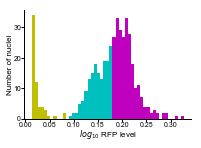

In [30]:
# create cell genotype classifier (operates on cells)
N = 3
gd = {0:0, 1:1, 2:2}
colors = ['y', 'c', 'm'][:3]
cmap = ListedColormap(colors, 'indexed', N=3)
classifier = CellClassifier.from_cells(df, classify_on='r', n=N, log=False, genotype_dict=gd, cmap=cmap)

fig, ax = plt.subplots(figsize=(3, 2))
_ = classifier.show(ax=ax)

#fig.savefig('../graphics/cell_classification.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)

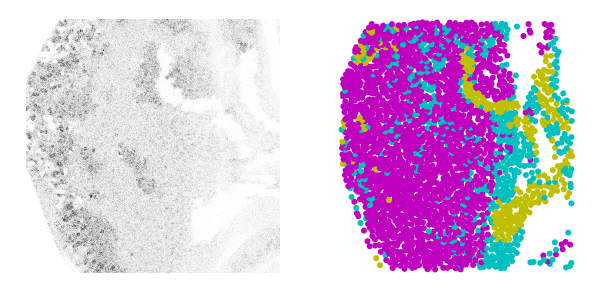

In [31]:
show_layer(stack[3], classifier)

In [391]:
for layer in stack:
    annotate_layer(layer, classifier, plot=True, dpi=100)

# Create cell genotype classifier

In [6]:
# compile all data for defining genotype thresholds
control_df = control.compile_measurements()
mutant_df = mutant.compile_measurements()
overall_df = pd.concat((control_df, mutant_df))
df = overall_df[overall_df.im_label!=-1]
df = df[df.near_furrow]

Text(0,0.5,'Number of nuclei')

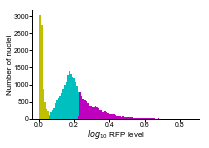

In [54]:
# create cell genotype classifier (operates on cells)
N = 9
genotype_dict = {0:0, 1:1, 2:1, 3: 1, 4: 2, 5:2, 6:2, 7:2, 8:2}
fig, ax = plt.subplots(figsize=(3, 2))
colors = ['y', 'c', 'm', 'k', 'r', 'g'][:3]
cmap = ListedColormap(colors, 'indexed', N=3)
cell_classifier = CellClassifier.from_cells(df, classify_on='r', n=N, log=False, genotype_dict=genotype_dict, cmap=cmap)
#cell_classifier = CellClassifier.from_im_clusters(df, classify_on='r_normalized', n=N, log=True, genotype_dict=genotype_dict, cmap=cmap)
_ = cell_classifier.show(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('$log_{10}$ RFP level', fontsize=8)
ax.set_ylabel('Number of nuclei', fontsize=8)

In [88]:
# fig, ax = plt.subplots(figsize=(2, 1))
# bins = np.linspace(cell_classifier.x.min(), cell_classifier.x.max(), 100)
# _ = ax.hist(cell_classifier.x, bins=bins)

Text(0,0.5,'Number of nuclei')

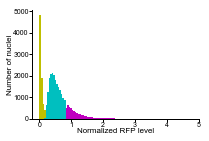

In [9]:
# fig, ax = plt.subplots(figsize=(3, 2))
# cell_classifier._show(10**cell_classifier.x, cell_classifier.labels, ax=ax)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xlabel('Normalized RFP level', fontsize=8)
# ax.set_ylabel('Number of nuclei', fontsize=8)

# apply to all discs

In [24]:
""" ANNOTATE ALL LAYERS """
for experiment in (control, mutant):
    for stack in experiment:
        for layer in stack:
            #if layer.include:
            try:
                annotate_layer(layer, cell_classifier, plot=True, dpi=100)
            except:
                print('FAIL', stack.disc_name, layer.layer_id)
        print('Finished', stack.disc_name)

Finished 28
Finished 29
Finished 30
Finished 31
Finished 55
Finished 56
Finished 6
Finished 7
Finished 15
Finished 16
Finished 17
Finished 19
Finished 20
Finished 24
Finished 25
Finished 26
Finished 34
Finished 35
Finished 36
Finished 42
Finished 43
Finished 44
Finished 46
Finished 47
Finished 48
Finished 49
Finished 50
Finished 51
Finished 52
Finished 53


In [456]:
""" ANNOTATE ALL LAYERS """
for experiment in (control, mutant):
    for stack in experiment:
        for layer in stack:
            try:
                mark_clone_boundaries(layer)
                layer.save_contours()
            except:
                print(stack.disc_name, layer.layer_id)

# Check annotation

In [62]:
disc = mutant[9]
layer = disc[0]
disc.disc_name

'26'

(-83.70572048734462, 2129.6981708125445, 2133.7531919212565, -88.7816831174566)

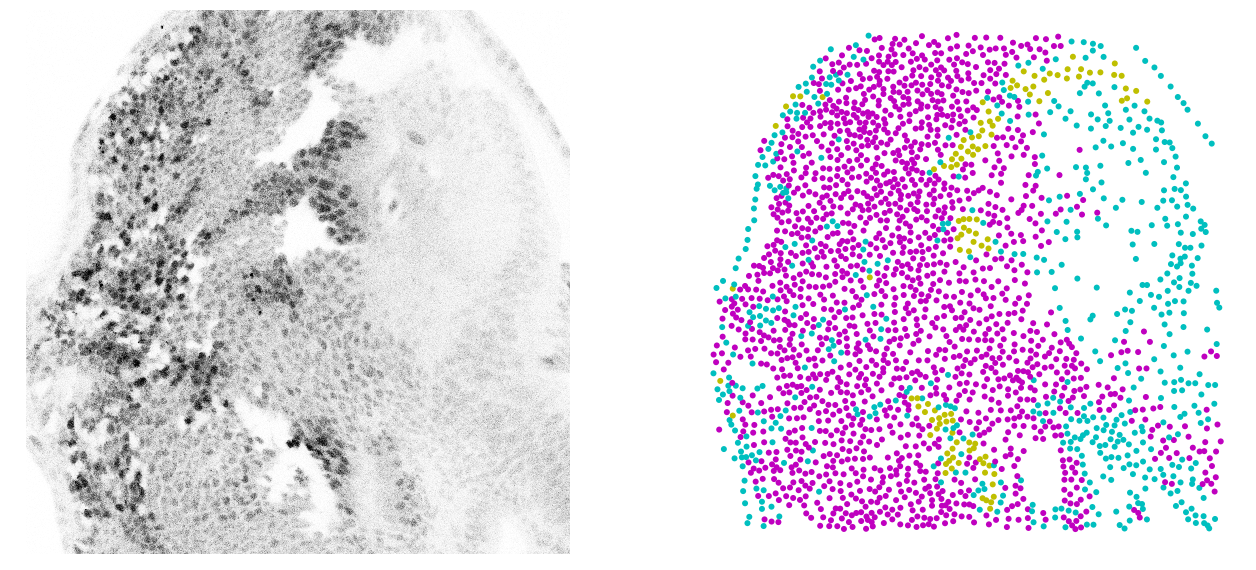

In [59]:
labels = cell_classifier(layer.df)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(22, 10))
xy = layer.df[['centroid_x', 'centroid_y']].values
_ = layer.get_channel('r').show(segments=False, ax=ax0, cmap=plt.cm.Greys)
ax1.scatter(*xy.T, c=labels, cmap=cell_classifier.cmap, lw=0)
ax1.invert_yaxis()
ax1.axis('off')

In [18]:
from modules.annotation import CloneMask

from modules.io import IO
import gc


def annotate_layer(layer, cell_classifier, plot=True, dpi=100):
    
    # assign genotype to all cells in layer
    clone_classifier = CloneClassifier.from_layer(layer, cell_classifier)
    layer.df['genotype'] = clone_classifier.genotypes
    layer.df['km_label'] = cell_classifier(layer.df)
    mark_clone_boundaries(layer)
    
    # instantiate IO
    io = IO()
    
    # save updated contours
    contours = layer.df.to_json()
    io.write_json(os.path.join(layer.path, 'contours.json'), contours)
    
    if plot:
        
        # visualize clones for current layer
        fig, ax = plt.subplots(figsize=(10, 10))    
        layer.annotation.clone_mask = CloneMask.from_layer(layer)
        _ = layer.get_channel('r').show(segments=False, ax=ax, cmap=plt.cm.Greys)
        layer.annotation.plot_clones(ax=ax)

        # set image keyword arguments
        im_kw = dict(format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

        # save figure
        fig.axes[0].axis('off') 
        fig.savefig(os.path.join(layer.path, 'annotation.png'), **im_kw)
        fig.clf()
        plt.close(fig)
        gc.collect()



    



In [43]:
from modules.annotation import CloneMask
from collections import Counter
from modules.io import IO
import gc



def mark_clone_boundaries(layer):
    edges = layer.annotation.graph.edges
    assign_genotype = np.vectorize(dict(layer.df.genotype).get)
    edge_genotypes = assign_genotype(edges)
    boundaries = edge_genotypes[:, 0] != edge_genotypes[:, 1]
    boundary_nodes = np.unique(edges[boundaries])
    layer.df['boundary'] = False
    layer.df.loc[boundary_nodes, 'boundary'] = True

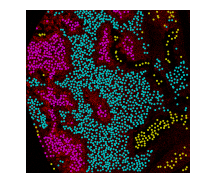

In [59]:
# create axis
fig, ax = plt.subplots(figsize=(3, 3))
_ = layer.get_channel('r').show(ax=ax, segments=False, cmap=None)
_ = ax.axis('off')
cmap = ListedColormap(['y', 'c', 'm'], 'indexed', 3)


fg = layer.df[~layer.df.boundary]
ax.scatter(fg.centroid_x, fg.centroid_y, c=fg.genotype, s=1, cmap=cmap, vmin=0, vmax=3)

fig.savefig('../graphics/boundary_selection.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)